In [42]:
import pandas as pd
import data_util
from tqdm.notebook import tqdm
#from tqdm import tqdm_notebook as tqdm
from data_generator import DataGenerator
from state_util import StateUtil
from tec_an import TecAn
import numpy as np
from data_util import *
import threading
import multiprocessing

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import scikitplot as skplt


from tensorflow.keras.layers import InputLayer, BatchNormalization, GlobalMaxPool1D, Bidirectional, Dense, Flatten, Conv2D, LeakyReLU, Dropout, LSTM, GRU, Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import tensorflow.keras as keras
import random



from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score


In [19]:
import pandas as pd
import data_util
from tqdm import tqdm_notebook as tqdm
from data_generator import DataGenerator
from state_util import StateUtil
from tec_an import TecAn
import numpy as np



In [20]:
path = "./data/"
trainX_raw, trainY_raw = load_data("", "train", path)
valX_raw, valY_raw = load_data("", "Val", path)

#trainX_balanced, trainY_balanced = get_balanced_set(trainX_raw, trainY_raw)

valX, valY = valX_raw, valY_raw

features = trainX_raw.shape[-1]


In [21]:
#print(Counter(trainY))


X_over, y_over = get_balanced_set(trainX_raw, trainY_raw)

print()
print("{} {}".format(Counter(y_over), Counter(trainY_raw)))

normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=(features,))
normalizer.adapt(X_over)

print("{} {} | {} {}".format(X_over.shape, y_over.shape, valX.shape, valY.shape))



Counter({0: 2706, 1: 2706}) Counter({0: 2706, 1: 1858})
(5412, 26) (5412,) | (505, 26) (505,)


In [22]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)


def get_balanced_set(x, y):
    oversample = RandomOverSampler(sampling_strategy='minority')
    #print(Counter(y))
    X_over, y_over = oversample.fit_resample(x, y)
    #print(Counter(y_over))
    return X_over, y_over


metric = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

metric = 'accuracy'

In [23]:
%%time

def get_full_model(
                  features = 3, 
                  layers = 1, 
                  units = 5, 
                  optimizer='Adam',
                  activation='relu',
                  k_reg=regularizers.l2(0.01),
                  init='glorot_uniform',
                  lays_seqs = 3
                 ):

    set_seeds()
    
    #print("{} {}".format(activation, optimizer))

    model = Sequential()

    #, input_shape=(seqs, features)
    
    model.add(normalizer)
        
    model.add(Dense(units, 
                  kernel_initializer=init,
                  kernel_regularizer=k_reg,
                  activation=activation))
    

    for lay in range(int(layers)):
        model.add(Dense(units, 
                        kernel_initializer=init, 
                        kernel_regularizer=k_reg,
                        activation=activation))

    model.add(Dropout(0.5))

    model.add(Dense(1, 
                  kernel_initializer=init,
                  kernel_regularizer=k_reg,
                  activation='sigmoid')) 

    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=[metric])
    
    return model


#model = get_rnn_model(**params)
#model.summary()

CPU times: user 52 µs, sys: 2 µs, total: 54 µs
Wall time: 59.1 µs


In [24]:
from sklearn.metrics import classification_report, precision_score

def eval_data(model, x, y):

    #print(model.evaluate(x, y))

    pred = np.where(model.predict(x) > 0.5,1,0)

    print("Confusion Matrix {} {}".format(pred.shape, y.shape))
    print(skplt.metrics.plot_confusion_matrix(y, pred, normalize=False))
    print(precision_score(y, pred))




In [35]:
%%time

# Get_full_model

from tensorflow.keras import layers
from tensorflow.keras import regularizers



model = KerasClassifier(build_fn=get_full_model, 
                        validation_data = (valX, valY),
                        verbose=0
                       )
# grid search epochs, batch size and optimizer
optimizers = [
              "Adadelta",
              "Nadam"
              #, "Adam"
]

init = [
        'glorot_uniform', 
        #, 'normal' 
        'he_uniform'
        ]

activation = [
        #'softmax', 
        #'softplus', 
        #'softsign', 
        'tanh', 
        'relu', 
        #'sigmoid', 
        'hard_sigmoid', 
        #'linear'
        ]

epochs = [100]
batches = [64]
layers = [5, 15, 20]
units = [16, 32]
regs = [ "l2", "l1"]
lays_seqs = [5, 10]

#get_simple_model(features[0]).summary()

ea = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    restore_best_weights=True
)

from sklearn.metrics import make_scorer, accuracy_score, f1_score


X_train, Y_train = trainX_raw, trainY_raw

x_norm = normalizer(trainX_raw).numpy()

def gridSearch(x, y, clf = model):
    
    

    param_grid = dict(
        #seqs = seqs,
        optimizer=optimizers, 
        epochs=epochs, 
        batch_size=batches,
        layers = layers,
        units = units,
        features = [features],
        #lays_seqs = lays_seqs,
        k_reg=regs,
        activation = activation
        )


    scorer = make_scorer(accuracy_score)

    clf_grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scorer, cv=5)


    clf_grid.fit(x, y)
    best_param = clf_grid.best_params_
    print(best_param)
    print(clf_grid.best_score_)

    return clf_grid



CPU times: user 3.41 ms, sys: 2.02 ms, total: 5.43 ms
Wall time: 3.22 ms


In [29]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.feature_selection import RFECV

train_X, train_y = x_norm, Y_train

test_X, test_y = valX, valY

feature_names = ['F{}'.format(i) for i in range(26)]


train_pool = Pool(train_X, train_y, feature_names=feature_names)
test_pool = Pool(valX, test_y, feature_names=feature_names)

rfe = RFECV(model,
            #min_features_to_select = 20,
            step=1, 
            verbose=0,
            cv=5)
rfe = rfe.fit(train_X, train_y)


ValueError: when `importance_getter=='auto'`, the underlying estimator KerasClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [36]:
clf_grid = gridSearch(X_train, Y_train, model)

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/samirantonio/opt/miniconda3/envs/py3/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary cla

{'activation': 'tanh', 'batch_size': 64, 'epochs': 100, 'features': 26, 'k_reg': 'l2', 'layers': 5, 'optimizer': 'Nadam', 'units': 32}
0.5938291443285102


In [44]:
%%time

param_test = {'activation': 'tanh', 
              'features': 26, 'k_reg': 'l2', 'layers': 5, 'optimizer': 'Nadam',
              'units': 32}

#model = get_full_model(**clf_grid.best_params_)
model = get_full_model(**param_test)


model.fit(
          X_over, y_over,
          epochs=100, 
          verbose=True,
          batch_size=64,
          callbacks=[ea],
          validation_data = (valX, valY),
          )

#model.summary()

Epoch 1/100
85/85 [==============================] - 3s 6ms/step - loss: 2.4259 - accuracy: 0.5443 - val_loss: 1.8384 - val_accuracy: 0.6337
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 1.7109 - accuracy: 0.6005 - val_loss: 1.3300 - val_accuracy: 0.6297
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 1.2515 - accuracy: 0.6098 - val_loss: 1.0213 - val_accuracy: 0.6356
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 0.9829 - accuracy: 0.6051 - val_loss: 0.8497 - val_accuracy: 0.6455
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.8416 - accuracy: 0.5981 - val_loss: 0.7706 - val_accuracy: 0.6396
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.7730 - accuracy: 0.5925 - val_loss: 0.7300 - val_accuracy: 0.6376
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.7401 - accuracy: 0.6033 - val_loss: 0.7107 - val_accuracy: 0.6475
Epoch 8/100
8

Confusion Matrix (5412, 1) (4564,)


ValueError: Found input variables with inconsistent numbers of samples: [4564, 5412]

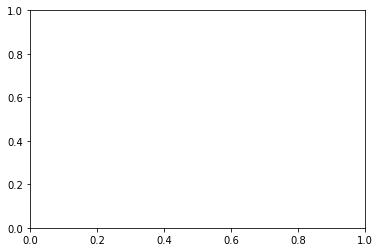

In [43]:
eval_data(model, X_over, Y_train)

In [ ]:
eval_data(model, rfe.transform(valX), valY)
